In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import poppy
import astropy.units as u
import logging
logging.basicConfig(level=logging.DEBUG)
from astropy.io import fits
from astropy.modeling import models, fitting
import tifffile
import numpy as np
import matplotlib.colors as mcolors
from astropy.stats import sigma_clip
logging.getLogger().setLevel(logging.INFO)
import photutils
import time
import datetime as dt
from turbustat.statistics import PowerSpectrum
from scipy import fftpack
import nbformat
import plotly.graph_objects as go
from PIL import Image

# Colormap
dark_yellow = [ '#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']

custom_cmap = mcolors.LinearSegmentedColormap.from_list("DarkYellow", dark_yellow)
gradient = np.linspace(0, 1, 256).reshape(1, -1)

In [2]:
# File containing the images
file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\Algol_1kHz_1_MMStack_Pos0.ome.tif")

immagini = tifffile.imread(file) 

# Define a count per pixel threshold to find the speckles in the images
speckle_threshold=7000 #1100 #7000 #9500 #8000 #9000 #6500 #9000

# Plate scale arcseconds/pixels
plate_scale = 0.0376

# Diffraction limit of the telescope
aperture = 1.82                                                     # Aperture of the telescope (in meters)
wavelength = 700e-9                                                 # Reference wavelenght (in meters) 

diffraction_limit_radians = 2*1.22 * wavelength / aperture          # Diameter of the Airy disk
diffraction_limit_arcseconds = diffraction_limit_radians * 206265
print("Diffraction limit in arcseconds and pixels: ",diffraction_limit_arcseconds)

#Radius used to check for speckles (in pixels)
check_radius = int(diffraction_limit_arcseconds/plate_scale) #4 corrisponde al diametro del disco di airy in pixel
print ("Check radius in pixels: ", check_radius)

def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)



Diffraction limit in arcseconds and pixels:  0.19357176923076921
Check radius in pixels:  5


## Image stack

In [13]:

ome_data = tifffile.imread(file)
stacked_image = np.mean(ome_data, axis=0)

### Immagine prova

(1127, 2002)


<>:1: SyntaxWarning:

invalid escape sequence '\p'

<>:1: SyntaxWarning:

invalid escape sequence '\p'

C:\Users\buonc\AppData\Local\Temp\ipykernel_23064\1429857575.py:1: SyntaxWarning:

invalid escape sequence '\p'



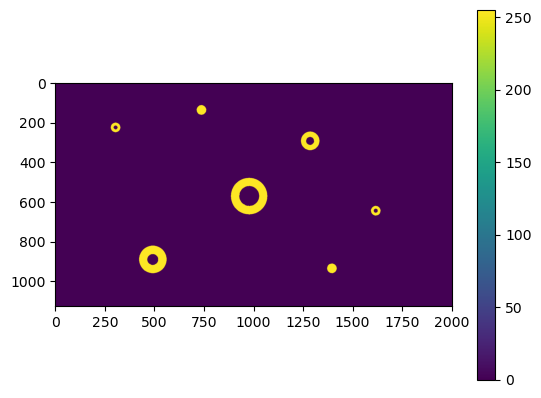

In [26]:
image = np.asarray(Image.open('immagini\prova_fft.png'))
print (image.shape)
imgplot = plt.imshow(image)
plt.colorbar(imgplot, orientation='vertical')

## Power spectrum 1

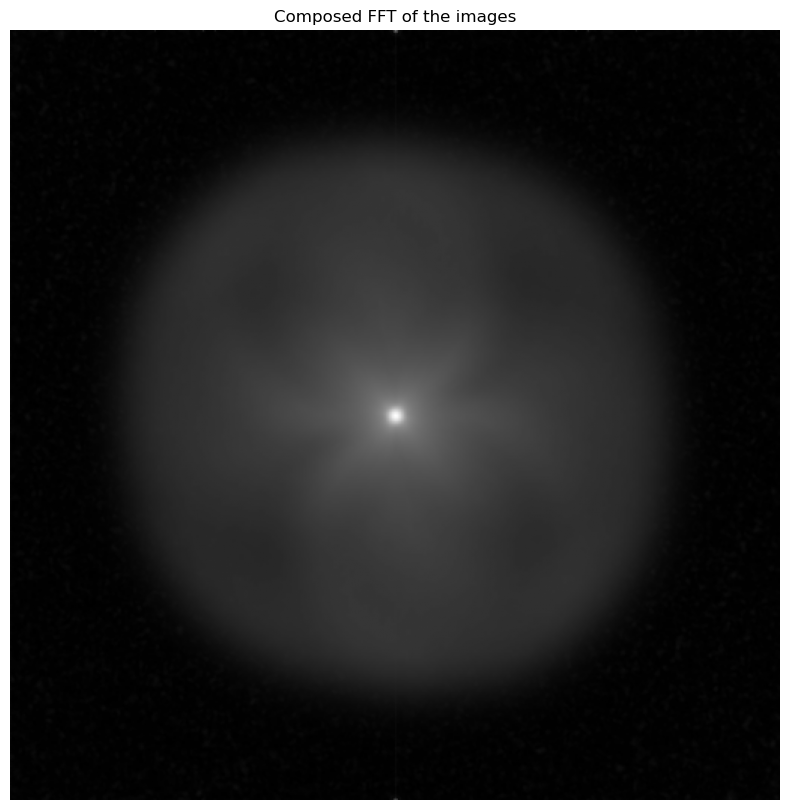

In [3]:
sum_ft = 0

for i in range(4999):
    imagenumber = 0 + i 
    data = immagini[imagenumber]

    data_raw = data.copy()
    data_clean = data_raw.copy()
    background_level = np.median(data_raw)
    data = data_raw - background_level
    data[data < 0] = 0

    image = data.copy()
    if image.ndim == 3:
        image = image[:, :, :3].mean(axis=2) 
    elif image.ndim == 2:
        image = image  
    else:
        raise ValueError("Unexpected image dimensions: {}".format(image.shape))

    ft = calculate_2dft(image)
    sum_ft += np.abs(ft)


plt.figure(figsize=(10, 10))
plt.set_cmap('gray')
plt.imshow(np.log(sum_ft))
plt.axis("off")
plt.title("Composed FFT of the images")
plt.show()

hdu = fits.PrimaryHDU(sum_ft)
hdul = fits.HDUList([hdu])
hdul.writeto('outputs/composed_fft.fits', overwrite=True)


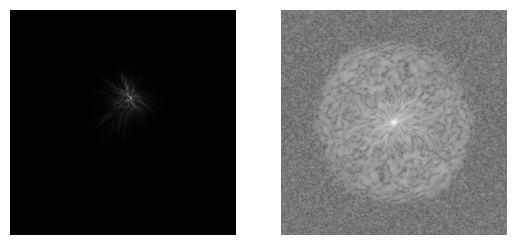

In [5]:


imagenumber = 500


data = immagini[imagenumber]
data_raw = data.copy()
data_clean = data_raw.copy()    
background_level = np.median(data_raw)
data = data_raw - background_level
data[data < 0] = 0

image = data.copy()

ft = calculate_2dft(image)
plt.subplot(121)
plt.imshow(image)
plt.axis("off")
plt.subplot(122)
plt.imshow(np.log(abs(ft)))
plt.axis("off")
plt.show()




## Inverse FFT

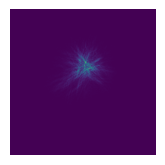

In [4]:
# Calculate the inverse Fourier transform of 
# the Fourier transform
ift = np.fft.ifftshift(ft)
ift = np.fft.ifft2(ift)
ift = np.fft.fftshift(ift)
ift = ift.real  # Take only the real part
plt.subplot(133)
plt.imshow(ift)
plt.axis("off")
plt.show()

# Power spectrum

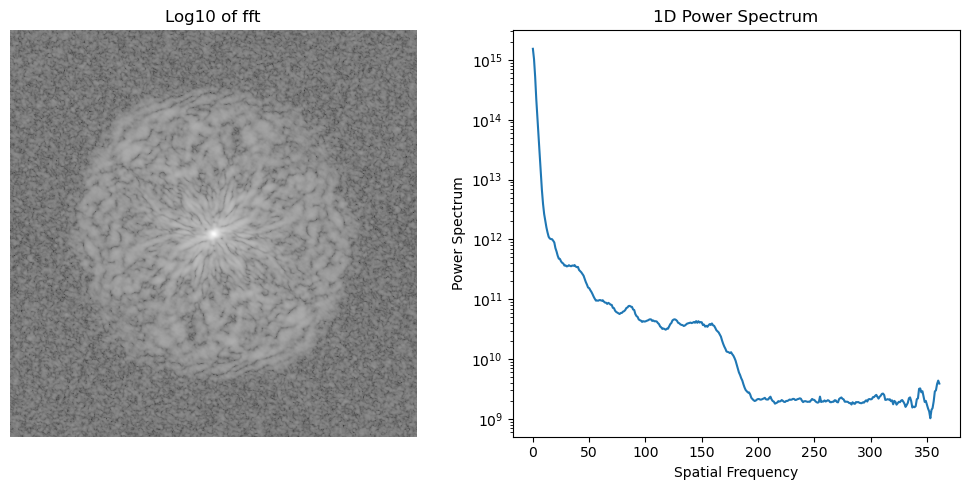

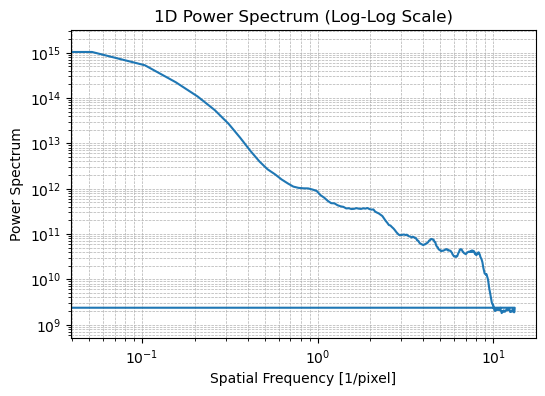

In [8]:


imagenumber = 500
data = immagini[imagenumber]
data_raw = data.copy()
data_clean = data_raw.copy()    
background_level = np.median(data_raw)
data = data_raw - background_level
data[data < 0] = 0

image = data.copy()
#image = image[:1022, :1022]
# Define a function for azimuthal averaging
def azimuthalAverage(image, center=None):
	"""
	Calculate the azimuthally averaged radial profile.

	Parameters:
	-----------
	image : 2D numpy array
		The 2D image
	center : tuple of int, optional
		The (x, y) pixel coordinates used as the center. If None, the center of the image is used.

	Returns:
	--------
	radial_prof : 1D numpy array
		The azimuthally averaged radial profile
	"""
	y, x = np.indices(image.shape)
	if center is None:
		center = (x.max() / 2, y.max() / 2)

	r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
	r = r.astype(int)

	tbin = np.bincount(r.ravel(), image.ravel())
	nr = np.bincount(r.ravel())
	radial_prof = tbin / nr
	return radial_prof

# Use the azimuthalAverage function instead of radialProfile.azimuthalAverage

F1 = fftpack.fft2(image)
# Now shift the quadrants around so that low spatial frequencies are in
# the center of the 2D fourier transformed image.
F2 = fftpack.fftshift( F1 )

# 2D power spectrum
psd2D = np.abs( F2 )**2

#azimuthally averaged 1D power spectrum
psd1D = azimuthalAverage(psd2D)

# Plot the 2D power spectrum
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(psd2D), cmap='gray')
plt.title("Log10 of fft")
plt.axis("off")

# Plot the azimuthally averaged 1D power spectrum
plt.subplot(1, 2, 2)
plt.semilogy(psd1D)
plt.title("1D Power Spectrum")
plt.xlabel("Spatial Frequency")
plt.ylabel("Power Spectrum")

plt.tight_layout()
plt.show()

# Convert spatial frequency to arcseconds^-1
pixel_scale = plate_scale  # Plate scale in arcseconds/pixel
spatial_frequency = np.fft.fftfreq(image.shape[0], d=pixel_scale)

# Plot the azimuthally averaged 1D power spectrum in log-log scale with correct units
plt.figure(figsize=(6, 4))
plt.loglog(spatial_frequency[:len(psd1D)], psd1D)
plt.title("1D Power Spectrum (Log-Log Scale)")
plt.xlabel("Spatial Frequency [1/pixel]")
plt.ylabel("Power Spectrum")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


## Con Turbustat

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning:

Header missing beam information.

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning:

Degrees of freedom <= 0 for slice.

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_pspec2.py:483: UserWarning:

The elliptical parameter is close to 1. The field may be isotropic and the fit is not converging to 1. Consider fitting with `fix_ellip_params=True`, which forces the ellipticity to 1.

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\elliptical_powerlaw.py:253: RuntimeWarning:

divide by zero encountered in log10



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     2481.
Date:                Thu, 01 May 2025   Prob (F-statistic):          1.42e-163
Time:                        12:10:20   Log-Likelihood:                -60.292
No. Observations:                 362   AIC:                             124.6
Df Residuals:                     360   BIC:                             132.4
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8241      0.038    233.711      0.0

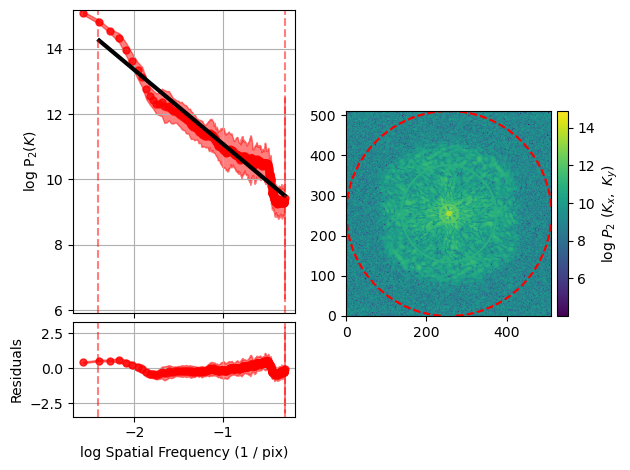

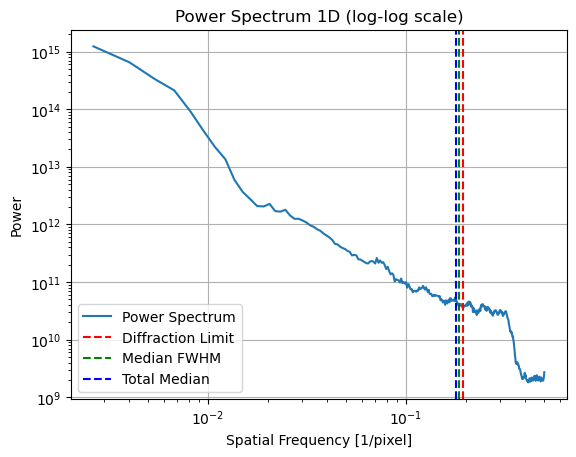

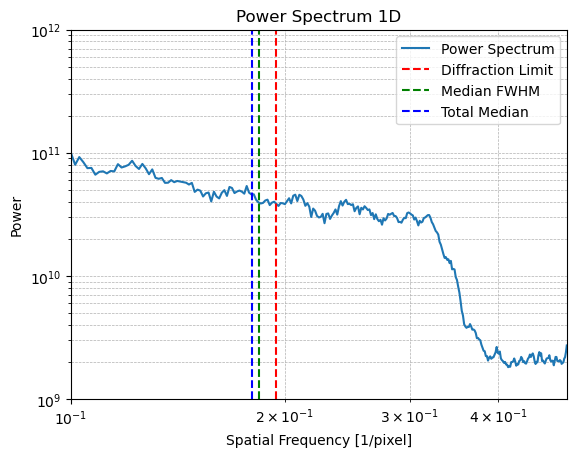

In [44]:


from astropy.io.fits import Header
from scipy.signal import find_peaks

#################################################################################
imagenumber = 1500
data = immagini[imagenumber]
data_raw = data.copy()
data_clean = data_raw.copy()    
background_level = np.median(data_raw)
data = data_raw - background_level
data[data < 0] = 0
image = data.copy()
#############################################################


#SE è DATACUBE ALLORA SI FA image = image [0,:,:] dove il numero selezione l'immagine del cubo
#image = fits.getdata('outputs/composed_fft.fits') #image[0,:,:] #image[0,:,:] #image[imagenumber,:,:] #image[0,:,:]
header = Header()
header['CDELT1'] = 1.0 # scala dei pixel lungo l'asse X (in pixel se si mette la plate scale allora è in arcsec)
header['CDELT2'] = 1.0  # scala dei pixel lungo l'asse Y


# Usa distanza fittizia 
pspec = PowerSpectrum(image, header=header, distance=1 * u.pc)
pspec.run(verbose=True, xunit=u.pix**-1)#, low_cut=0.1, high_cut=0.01) 

plt.loglog(pspec.freqs.value, pspec.ps1D, label="Power Spectrum")
plt.xlabel('Spatial Frequency [1/pixel]')
plt.ylabel('Power')
plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale), color='r', linestyle='--', label='Diffraction Limit')
plt.axvline(x=1/(0.204/plate_scale), color='g', linestyle='--', label='Median FWHM')
plt.axvline(x=1/(0.209/plate_scale), color='blue', linestyle='--', label='Total Median')
plt.title('Power Spectrum 1D (log-log scale)')
plt.grid(True)
plt.legend()
plt.show()

plt.loglog(pspec.freqs.value, pspec.ps1D, label="Power Spectrum")
plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale), color='r', linestyle='--', label='Diffraction Limit')
plt.axvline(x=1/(0.204/plate_scale), color='g', linestyle='--', label='Median FWHM')
plt.axvline(x=1/(0.209/plate_scale), color='blue', linestyle='--', label='Total Median')
plt.xlim(0.1, pspec.freqs.value.max())
plt.xlim(0.1, pspec.freqs.value.max())
plt.ylim(1e9, 1e12)
plt.xlabel('Spatial Frequency [1/pixel]')
plt.ylabel('Power')
plt.title('Power Spectrum 1D')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()



fig = go.Figure()
fig.add_trace(go.Scatter(
    x=pspec.freqs.value,
    y=pspec.ps1D,
    mode='lines',
    name='Power Spectrum'
))

fig.update_layout(
    title="Power Spectrum 1D (Interactive)",
    xaxis_title="Frequenza spaziale [1/pixel]",
    yaxis_title="Potenza",
    xaxis_type="log",
    yaxis_type="log",
    template="plotly_white",
    showlegend=True
)
fig.show()


# frequenze = pspec.freqs        # in unità di 1/pixel
# potenza = pspec.ps1D           # spettro radiale
# pendenza = pspec.slope         # pendenza del fit
# print(f"Frequenze: {frequenze}")
# print(f"Potenza: {potenza}")
# print(f"Pendenza: {pendenza}")


# Passband filter

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_pspec2.py:483: UserWarning: The elliptical parameter is close to 1. The field may be isotropic and the fit is not converging to 1. Consider fitting with `fix_ellip_params=True`, which forces the ellipticity to 1.
  warnings.warn("The elliptical parameter is close to 1. The field "
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nan

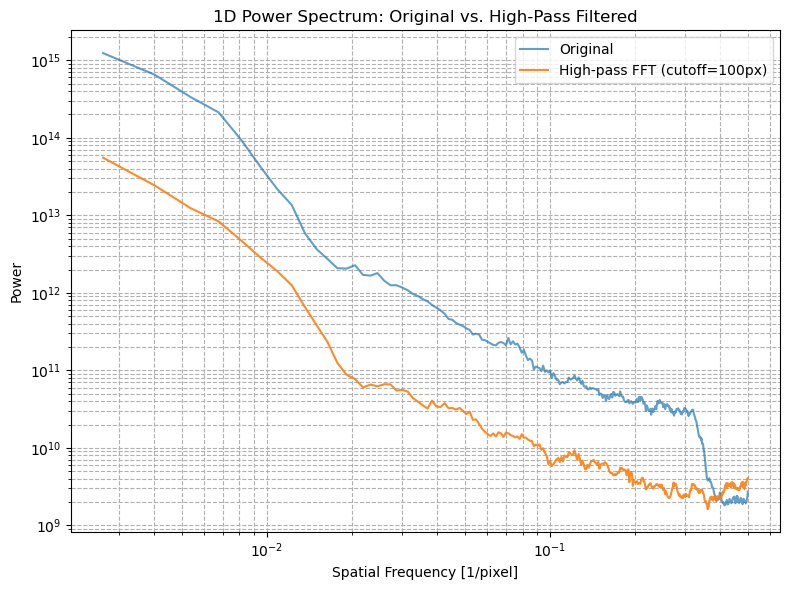

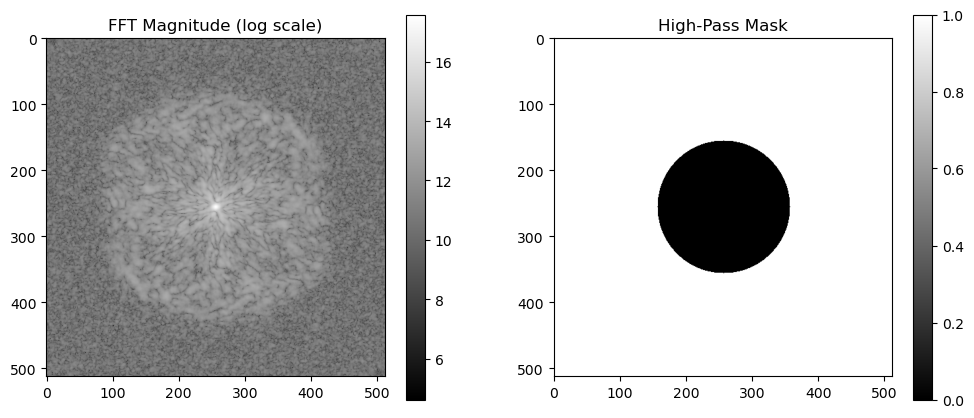

In [ ]:
import numpy as np
from astropy.io.fits import Header
import astropy.units as u
from turbustat.statistics import PowerSpectrum
import matplotlib.pyplot as plt


def high_pass_filter_fft(img, cutoff):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2

    #circular mask
    mask = np.ones((rows, cols), dtype=np.float32)
    y, x = np.ogrid[:rows, :cols]
    mask_area = (x - ccol)**2 + (y - crow)**2 <= cutoff**2
    mask[mask_area] = 0

    #Apply mask in Fourier space
    fshift_filtered = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    
    return np.abs(img_back), mask

imagenumber = 1500
data = immagini[imagenumber]
background_level = np.median(data)
data = data - background_level
data[data < 0] = 0
image = data.copy()

#High-Pass Filter
cutoff = 100  # Cutoff frequency in pixels
highpass, mask = high_pass_filter_fft(image, cutoff=cutoff)

#########################################################################################################
# Power Spectrum 
header = Header()
header['CDELT1'] = 1.0
header['CDELT2'] = 1.0
pspec_raw = PowerSpectrum(image, header=header, distance=1 * u.pc)
pspec_raw.run(verbose=False, xunit=u.pix**-1)

pspec_filtered = PowerSpectrum(highpass, header=header, distance=1 * u.pc)
pspec_filtered.run(verbose=False, xunit=u.pix**-1)

######################### PLOTS #############################
plt.figure(figsize=(8, 6))
plt.plot(pspec_raw.freqs.value, pspec_raw.ps1D, label='Original', alpha=0.7)
plt.plot(pspec_filtered.freqs.value, pspec_filtered.ps1D, label=f'High-pass FFT (cutoff={cutoff}px)', alpha=0.9)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Spatial Frequency [1/pixel]")
plt.ylabel("Power")
plt.title("1D Power Spectrum: Original vs. High-Pass Filtered")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()

# Visualize FFT magnitude and the mask
f = np.fft.fftshift(np.fft.fft2(image))
magnitude = np.log(np.abs(f) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(magnitude, cmap='gray')
plt.title("FFT Magnitude (log scale)")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title("High-Pass Mask")
plt.colorbar()
plt.show()




# Tentativo 2

In [ ]:
import numpy as np
from astropy.io.fits import Header
import astropy.units as u
from turbustat.statistics import PowerSpectrum
from scipy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt

#######################################################################################à
# high-pass filter
def create_highpass_filter(shape, cutoff):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    radius_squared = (x - ccol)**2 + (y - crow)**2
    mask = np.ones(shape, dtype=np.float32)
    mask[radius_squared < cutoff**2] = 0
    return fftshift(mask)

def create_lowpass_filter(shape, cutoff_low):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    radius_squared = (x - ccol)**2 + (y - crow)**2
    mask = np.zeros(shape, dtype=np.float32)
    mask[radius_squared < cutoff_low**2] = 1
    return fftshift(mask)

# high-pass filter application
def fourier_highpass_filter(image, cutoff):
    F_image = fft2(image)
    hp_filter = create_highpass_filter(image.shape, cutoff)
    F_filtered = F_image * hp_filter
    filtered_image = ifft2(F_filtered).real
    return filtered_image, hp_filter

# low-pass filter application
def fourier_lowpass_filter(image, cutoff_low):
    F_image = fft2(image)
    lp_filter = create_lowpass_filter(image.shape, cutoff_low)
    F_filtered = F_image * lp_filter
    filtered_image = ifft2(F_filtered).real
    return filtered_image, lp_filter

#####################################################################################################
###############################################################################################à
imagenumber = 500  
stacked = False
if stacked == True:
    data = np.sum(immagini[imagenumber:imagenumber + 3], axis=0)  # Sum of  images
    background_level = np.median(data)
    data = data - background_level
    data[data < 0] = 0
    image = data.copy()
else:
    data = immagini[imagenumber]
    data_raw = data.copy()
    background_level = np.median(data_raw)
    data = data_raw - background_level
    data[data < 0] = 0
    image = data.copy()
#################################################################################################à
# --------------------------------------------
# APPLY FOURIER-SPACE HIGH-PASS FILTER
image = np.asarray(Image.open('immagini\prova_fft.png'))

cutoff = 20#50  # Radius in pixels for cutoff frequency
cutoff_low = 200
highpass, hp_filter = fourier_highpass_filter(image, cutoff=cutoff)
lowpass, lp_filter = fourier_lowpass_filter(image, cutoff_low=cutoff_low)

# Check for NaNs or Infs in the filtered image
if np.any(np.isnan(highpass)) or np.any(np.isinf(highpass)):
    print("Warning: NaN or Inf values found in the filtered image!")

# Clip any negative values to zero
highpass = np.maximum(highpass, 0)
lowpass = np.maximum(lowpass, 0)

# Clean filtered images
highpass = np.nan_to_num(highpass)
lowpass = np.nan_to_num(lowpass)

#POWER SPECTRA
header = Header()
header['CDELT1'] = 1.0
header['CDELT2'] = 1.0
pspec_raw = PowerSpectrum(image, header=header, distance=1 * u.pc)
pspec_raw.run(verbose=False, xunit=u.pix**-1)

pspec_filtered = PowerSpectrum(highpass, header=header, distance=1 * u.pc)
pspec_filtered.run(verbose=False, xunit=u.pix**-1)


#PLOTS
plt.figure(figsize=(8, 6))
plt.plot(pspec_raw.freqs.value, pspec_raw.ps1D, label='Original', alpha=0.7)
plt.plot(pspec_filtered.freqs.value, pspec_filtered.ps1D, label=f'High-pass Filtered (cutoff={cutoff})', alpha=0.9)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Spatial Frequency [pix⁻¹]")
plt.ylabel("Power")
plt.title("1D Power Spectrum: Original vs High-Pass Filtered")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()

# FILTER PLOT
plt.figure()
plt.imshow(hp_filter, cmap='gray')
plt.title("High-Pass Filter in Fourier Space")
plt.colorbar()
plt.tight_layout()
plt.show()

plt.loglog(pspec_filtered.freqs.value, pspec_filtered.ps1D, label=f'High-pass Filtered (cutoff={cutoff})', alpha=0.9)
plt.xlabel('Spatial Frequency [1/pixel]')
plt.ylabel('Power')
plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale), color='r', linestyle='--', label='Diffraction Limit')
plt.axvline(x=1/(0.204/plate_scale), color='g', linestyle='--', label='Median FWHM')
plt.axvline(x=1/(0.209/plate_scale), color='blue', linestyle='--', label='Total Median')
plt.title('Power Spectrum 1D (log-log scale)')
plt.grid(True)
plt.legend()
plt.show()

plt.loglog(pspec_filtered.freqs.value, pspec_filtered.ps1D, label=f'High-pass Filtered (cutoff={cutoff})', alpha=0.9)
plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale), color='r', linestyle='--', label='Diffraction Limit')
plt.axvline(x=1/(0.204/plate_scale), color='g', linestyle='--', label='Median FWHM')
plt.axvline(x=1/(0.209/plate_scale), color='blue', linestyle='--', label='Total Median')
plt.xlim(0.1, pspec.freqs.value.max())
plt.xlim(0.1, pspec.freqs.value.max())
plt.ylim(1e9, 1e12)
plt.xlabel('Spatial Frequency [1/pixel]')
plt.ylabel('Power')
plt.title('Power Spectrum 1D')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

def plot_fourier_transform(image, title="2D Fourier Transform"):
    F_image = fft2(image) 
    F_image_shifted = fftshift(F_image)  
    magnitude = np.abs(F_image_shifted)  
    
    plt.figure(figsize=(6, 6))
    plt.imshow(np.log(magnitude + 1), cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

plot_fourier_transform(image, title="Original Image: 2D Fourier Transform")
plot_fourier_transform(hp_filter, title="Filtered Image: 2D Fourier Transform")
def plot_mask_with_circle(mask, cutoff, title="Mask with Circle"):
    plt.figure(figsize=(6, 6))
    plt.imshow(mask, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

plot_mask_with_circle(highpass, cutoff, title="Filtered Image")



<>:64: SyntaxWarning: invalid escape sequence '\p'
<>:64: SyntaxWarning: invalid escape sequence '\p'
C:\Users\buonc\AppData\Local\Temp\ipykernel_2992\2630155418.py:64: SyntaxWarning: invalid escape sequence '\p'
  image = np.asarray(Image.open('immagini\prova_fft.png'))
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")


# 3

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_pspec2.py:483: UserWarning: The elliptical parameter is close to 1. The field may be isotropic and the fit is not converging to 1. Consider fitting with `fix_ellip_params=True`, which forces the ellipticity to 1.
  warnings.warn("The elliptical parameter is close to 1. The field "
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nan

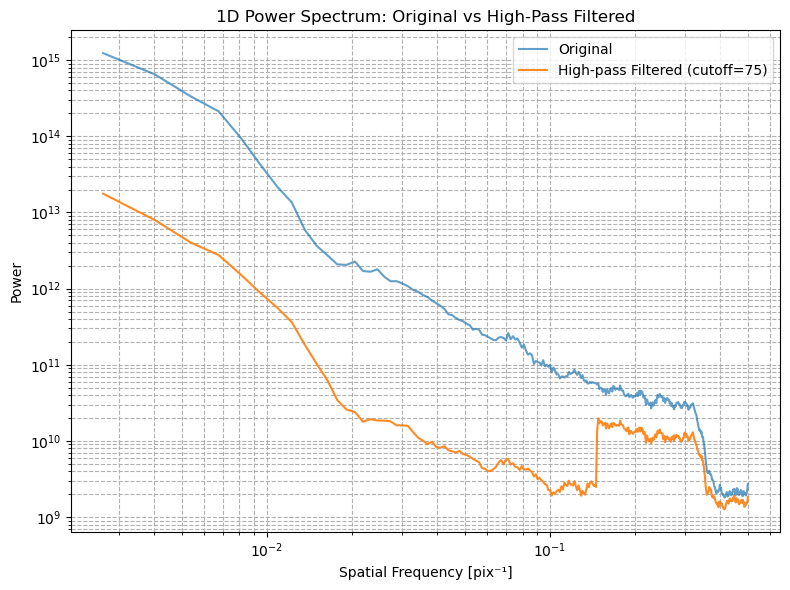

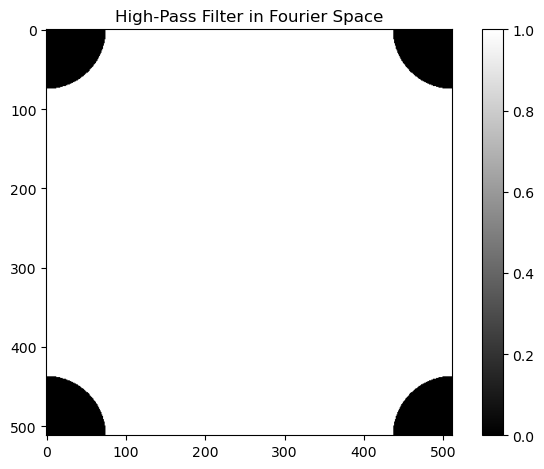

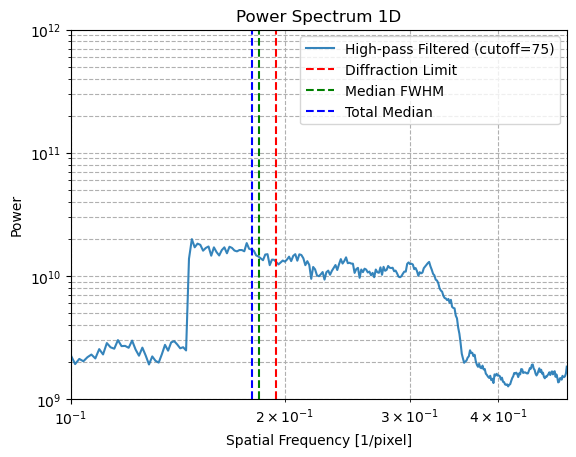

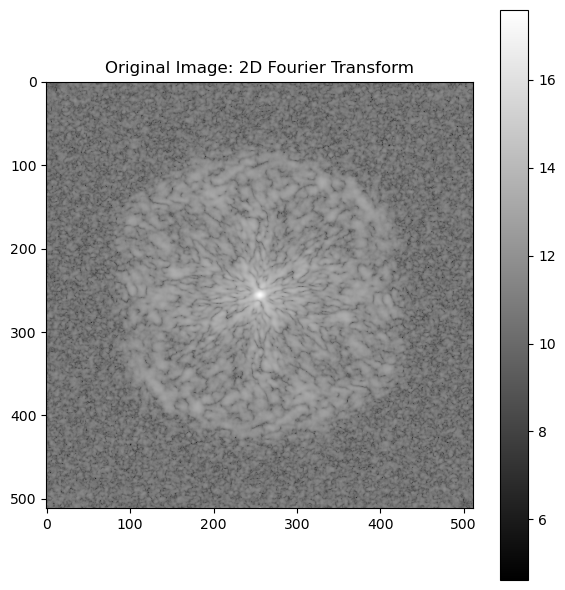

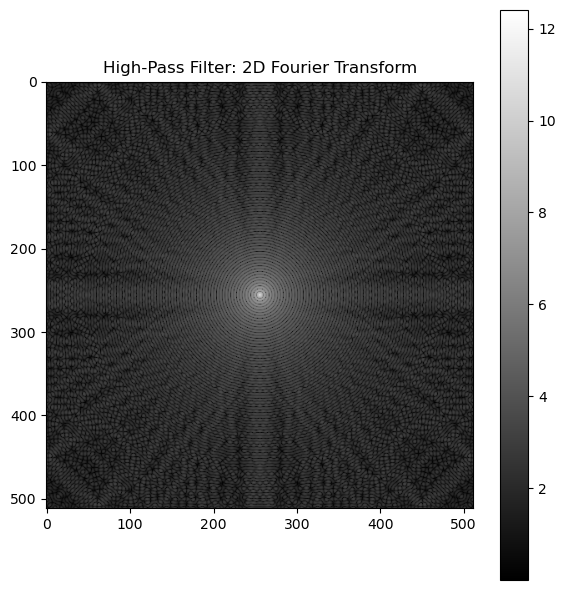

In [38]:
import numpy as np
from astropy.io.fits import Header
import astropy.units as u
from turbustat.statistics import PowerSpectrum
from scipy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt

# --------------------------------------------
# High-pass filter creation (zeroes out low frequencies)
def create_highpass_filter(shape, cutoff):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    radius_squared = (x - ccol)**2 + (y - crow)**2
    mask = np.ones(shape, dtype=np.float32)
    mask[radius_squared < cutoff**2] = 0  # Zero out low-frequency regions
    return fftshift(mask)

# Low-pass filter creation
def create_lowpass_filter(shape, cutoff_low):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    radius_squared = (x - ccol)**2 + (y - crow)**2
    mask = np.zeros(shape, dtype=np.float32)
    mask[radius_squared < cutoff_low**2] = 1  # Keep low-frequency regions
    return fftshift(mask)

# High-pass filter application (sets low frequencies to zero)
def fourier_highpass_filter(image, cutoff):
    F_image = fft2(image)  # Fourier transform of the image
    hp_filter = create_highpass_filter(image.shape, cutoff)  # High-pass filter mask
    F_filtered = F_image * hp_filter  # Apply the filter by setting low frequencies to zero
    filtered_image = ifft2(F_filtered).real  # Inverse FFT to get the filtered image
    return filtered_image, hp_filter

# Low-pass filter application (sets high frequencies to zero)
def fourier_lowpass_filter(image, cutoff_low):
    F_image = fft2(image)  # Fourier transform of the image
    lp_filter = create_lowpass_filter(image.shape, cutoff_low)  # Low-pass filter mask
    F_filtered = F_image * lp_filter  # Apply the filter by setting high frequencies to zero
    filtered_image = ifft2(F_filtered).real  # Inverse FFT to get the filtered image
    return filtered_image, lp_filter

# Load your image (adjust based on your data source)
imagenumber = 1500  # Image index in the cube
data = immagini[imagenumber]  # Your 2D image (e.g., from a data cube)
background_level = np.median(data)  # Subtract background
data = data - background_level
data[data < 0] = 0  # Remove negative values
image = data.copy()

# --------------------------------------------
# Apply high-pass and low-pass Fourier filters
cutoff = 75  # High-pass cutoff frequency (in pixels)
cutoff_low = 200  # Low-pass cutoff frequency (in pixels)
highpass, hp_filter = fourier_highpass_filter(image, cutoff=cutoff)
lowpass, lp_filter = fourier_lowpass_filter(image, cutoff_low=cutoff_low)

# --------------------------------------------
# Check for NaNs or Infs in the filtered image
if np.any(np.isnan(highpass)) or np.any(np.isinf(highpass)):
    print("Warning: NaN or Inf values found in the filtered image!")
    # Visualize filtered image to check artifacts
    plt.imshow(highpass, cmap='gray')
    plt.title("Filtered Image with NaNs/Infs")
    plt.colorbar()
    plt.show()

# --------------------------------------------
# Clip any negative values to zero (to avoid artifacts)
highpass = np.maximum(highpass, 0)
lowpass = np.maximum(lowpass, 0)

# --------------------------------------------
# Clean filtered images (remove NaN or Inf values)
highpass = np.nan_to_num(highpass)
lowpass = np.nan_to_num(lowpass)

# --------------------------------------------
# Header for power spectrum calculation (Assume pixel scale = 1)
header = Header()
header['CDELT1'] = 1.0  # Pixel scale in X (arcseconds/pixel)
header['CDELT2'] = 1.0  # Pixel scale in Y (arcseconds/pixel)

# --------------------------------------------
# Compute power spectra for original and filtered images
pspec_raw = PowerSpectrum(image, header=header, distance=1 * u.pc)
pspec_raw.run(verbose=False, xunit=u.pix**-1)

pspec_filtered = PowerSpectrum(highpass, header=header, distance=1 * u.pc)
pspec_filtered.run(verbose=False, xunit=u.pix**-1)

# --------------------------------------------
# Plot comparison of power spectra
plt.figure(figsize=(8, 6))
plt.plot(pspec_raw.freqs.value, pspec_raw.ps1D, label='Original', alpha=0.7)
plt.plot(pspec_filtered.freqs.value, pspec_filtered.ps1D, label=f'High-pass Filtered (cutoff={cutoff})', alpha=0.9)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Spatial Frequency [pix⁻¹]")
plt.ylabel("Power")
plt.title("1D Power Spectrum: Original vs High-Pass Filtered")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()

# --------------------------------------------
# Optional: Visualize the high-pass filter
plt.figure()
plt.imshow(hp_filter, cmap='gray')
plt.title("High-Pass Filter in Fourier Space")
plt.colorbar()
plt.tight_layout()
plt.show()

# Optional: Plot power spectrum with vertical lines for diffraction limit and median FWHM
plt.loglog(pspec_filtered.freqs.value, pspec_filtered.ps1D, label=f'High-pass Filtered (cutoff={cutoff})', alpha=0.9)
plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale), color='r', linestyle='--', label='Diffraction Limit')
plt.axvline(x=1/(0.204/plate_scale), color='g', linestyle='--', label='Median FWHM')
plt.axvline(x=1/(0.209/plate_scale), color='blue', linestyle='--', label='Total Median')
plt.xlim(0.1, pspec_raw.freqs.value.max())
plt.ylim(1e9, 1e12)
plt.xlabel('Spatial Frequency [1/pixel]')
plt.ylabel('Power')
plt.title('Power Spectrum 1D')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

# --------------------------------------------
# Visualize the Fourier Transform of the original and filtered image
def plot_fourier_transform(image, title="2D Fourier Transform"):
    F_image = fft2(image)  # Compute the 2D Fourier Transform of the image
    F_image_shifted = fftshift(F_image)  # Shift zero frequency to the center
    magnitude = np.abs(F_image_shifted)  # Take the magnitude
    
    plt.figure(figsize=(6, 6))
    plt.imshow(np.log(magnitude + 1), cmap='gray')  # Log scale for better visualization
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Visualize Fourier Transforms
plot_fourier_transform(image, title="Original Image: 2D Fourier Transform")
plot_fourier_transform(hp_filter, title="High-Pass Filter: 2D Fourier Transform")
